In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt

#bempp.api.enable_console_logging()

Setting the size of the element of the mesh and the center of the two spheres. The radius of the sphere is 1 and the distance between the boundary of them if 1. (Z/R=1)

In [2]:
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) 

Construct RWG and SNC in difference spaces.

We are defining an exponentially adapted trapezoid rule and choose the quadrature points accordingly.

In [5]:
size_mesh = [0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]
N = 5
lbound = .05
ubound = 4
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
result_ratio1 = np.empty((len(size_mesh),N), dtype='float64')


for index1, h in enumerate(size_mesh):
    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    for index2, point in enumerate(quad_points):
    
        wavenumber = -1j * np.log(point)

        op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
        op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
        op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
        op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

        blocked_op = BlockedOperator(2, 2)
        blocked_op[0, 0] = op11
        blocked_op[0, 1] = op12
        blocked_op[1, 0] = op21
        blocked_op[1, 1] = op22

        blocked_diag = BlockedOperator(2, 2)
        blocked_diag[0, 0] = op11
        blocked_diag[1, 1] = op22

        mat = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
        mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
        combined = np.linalg.inv(mat2).dot(mat)
        sign, logdet = slogdet(combined)
        result_ratio1[index1,index2] = logdet 

In [6]:
%matplotlib inline
from matplotlib.pyplot import figure

The left plot shows the relative log determinant with increasing imaginary wavenumber. The right plot uses a scale appropriate for the trapezoid quadrature rule.

In [9]:
Casimir_energy1 = []
for i in range(len(size_mesh)):
    Casimir_energy1.append(np.trapz(-result_ratio1[i,:] / quad_points, quad_points) / (2 * np.pi))

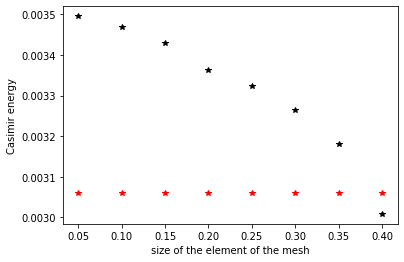

In [21]:
plt.plot(size_mesh,Casimir_energy1,'k*')
plt.plot(size_mesh, [0.00306,0.00306,0.00306,0.00306,0.00306,0.00306,0.00306,0.00306], 'r*')
plt.xlabel('size of the element of the mesh')
plt.ylabel('Casimir energy')
plt.savefig('Convergence_ratio1.pdf',bbox_inches='tight')

In [11]:
rate_conv1 = [] #linearly convergence
for i in range(6):
    rate_conv1.append(abs((Casimir_energy1[i+2]-Casimir_energy1[0]))/abs((Casimir_energy1[i+1]-Casimir_energy1[0])))

In [12]:
rate_conv1

[1.480043608584589,
 1.2323726865014357,
 1.131490366080964,
 1.1841746472011903,
 1.0911752652687392,
 1.0594785331479726]